In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 pip install fuzzywuzzy pip install python-Levenshtein  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 6.9 MB/s 
     |████████████████████████████████| 2.2 MB 65.0 MB/s 


In [ ]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633980 sha256=f6abdd96101a306985980586c6eb4a63537c33ea36a410b28a18dd87ad90d0d4
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import numpy as np
import tensorflow as tf

class AutoRec(object):

    def __init__(self, visibleDimensions, epochs=200, hiddenDimensions=50, learningRate=0.1, batchSize=100):

        self.visibleDimensions = visibleDimensions
        self.epochs = epochs
        self.hiddenDimensions = hiddenDimensions
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.optimizer = tf.keras.optimizers.RMSprop(self.learningRate)

    def Train(self, X):

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batchSize):
                epochX = X[i:i+self.batchSize]
                self.run_optimization(epochX)

            print("Trained epoch ", epoch)

    def GetRecommendations(self, inputUser):

        # Feed through a single user and return predictions from the output layer.
        rec = self.neural_net(inputUser)

        # It is being used as the return type is Eager Tensor.
        return rec[0]

    def neural_net(self, inputUser):

        #tf.set_random_seed(0)

        # Create varaibles for weights for the encoding (visible->hidden) and decoding (hidden->output) stages, randomly initialized
        self.weights = {
            'h1': tf.Variable(tf.random.normal([self.visibleDimensions, self.hiddenDimensions])),
            'out': tf.Variable(tf.random.normal([self.hiddenDimensions, self.visibleDimensions]))
            }

        # Create biases
        self.biases = {
            'b1': tf.Variable(tf.random.normal([self.hiddenDimensions])),
            'out': tf.Variable(tf.random.normal([self.visibleDimensions]))
            }

        # Create the input layer
        self.inputLayer = inputUser

        # hidden layer
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(self.inputLayer, self.weights['h1']), self.biases['b1']))

        # output layer for our predictions.
        self.outputLayer = tf.nn.sigmoid(tf.add(tf.matmul(hidden, self.weights['out']), self.biases['out']))

        return self.outputLayer

    def run_optimization(self, inputUser):
        with tf.GradientTape() as g:
            pred = self.neural_net(inputUser)
            loss = tf.keras.losses.MSE(inputUser, pred)

        trainable_variables = list(self.weights.values()) + list(self.biases.values())

        gradients = g.gradient(loss, trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

from surprise import AlgoBase
from surprise import PredictionImpossible
import numpy as np

class AutoRecAlgorithm(AlgoBase):

    def __init__(self, epochs=100, hiddenDim=100, learningRate=0.01, batchSize=100, sim_options={}):
        AlgoBase.__init__(self)
        self.epochs = epochs
        self.hiddenDim = hiddenDim
        self.learningRate = learningRate
        self.batchSize = batchSize

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        numUsers = trainset.n_users
        numItems = trainset.n_items

        trainingMatrix = np.zeros([numUsers, numItems], dtype=np.float32)

        for (uid, iid, rating) in trainset.all_ratings():
            trainingMatrix[int(uid), int(iid)] = rating / 5.0

        # Create an RBM with (num items * rating values) visible nodes
        autoRec = AutoRec(trainingMatrix.shape[1], hiddenDimensions=self.hiddenDim, learningRate=self.learningRate, batchSize=self.batchSize, epochs=self.epochs)
        autoRec.Train(trainingMatrix)

        self.predictedRatings = np.zeros([numUsers, numItems], dtype=np.float32)

        for uiid in range(trainset.n_users):
            if (uiid % 50 == 0):
                print("Processing user ", uiid)
            recs = autoRec.GetRecommendations([trainingMatrix[uiid]])

            for itemID, rec in enumerate(recs):
                self.predictedRatings[uiid, itemID] = rec * 5.0

        return self

    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')

        rating = self.predictedRatings[u, i]

        if (rating < 0.001):
            raise PredictionImpossible('No valid prediction exists.')

        return rating

import os
import csv
import sys
import re

from surprise import Dataset
from surprise import Reader

from collections import defaultdict

class boardgameLens:

    boardgameID_to_name = {}
    name_to_boardgameID = {}

    #ratingsPath =  '/content/drive/MyDrive/Colab Notebooks/Crawling/outcome/ratings.csv'
    #boardgamesPath = '/content/drive/MyDrive/Colab Notebooks/Crawling/outcome/boardgames.csv'
    ratingsPath = '/content/drive/MyDrive/Colab Notebooks/Crawling/outcome/userdata_rate_1021.csv'
    boardgamesPath = '/content/drive/MyDrive/Colab Notebooks/Crawling/outcome/bg_data_3.csv'
    def loadboardgameLensLatestSmall(self):

        # Look for files relative to the directory we are running from
        os.chdir(os.path.dirname(sys.argv[0]))

        ratingsDataset = 0
        self.boardgameID_to_name = {}
        self.name_to_boardgameID = {}

        reader = Reader(line_format='user item rating timestamp', sep='\t', skip_lines=1)

        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.boardgamesPath, newline='', encoding='UTF-8') as csvfile:
                boardgameReader = csv.reader(csvfile)
                next(boardgameReader)  #Skip header line
                for row in boardgameReader:
                    tmp_str = row[0].split("\t")
                    boardgameID = int(tmp_str[0])
                    boardgameName = tmp_str[1]
                    self.boardgameID_to_name[boardgameID] = boardgameName
                    self.name_to_boardgameID[boardgameName] = boardgameID

        return ratingsDataset

    def getUserRatings(self, user):
        userRatings = []
        hitUser = False
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                userID = int(row[0])
                if (user == userID):
                    boardgameID = int(row[1])
                    rating = float(row[2])
                    userRatings.append((boardgameID, rating))
                    hitUser = True
                if (hitUser and (user != userID)):
                    break

        return userRatings

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = defaultdict(int)
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                tmp_str = row[0].split("\t")
                boardgameID = int(tmp_str[1])
                ratings[boardgameID] += 1
        rank = 1
        for boardgameID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[boardgameID] = rank
            rank += 1
        return rankings

    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.boardgamesPath, newline='', encoding='ISO-8859-1') as csvfile:
            boardgameReader = csv.reader(csvfile)
            next(boardgameReader)  #Skip header line
            for row in boardgameReader:
                boardgameID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[boardgameID] = genreIDList
        # Convert integer-encoded genre lists to bitfields that we can treat as vectors
        for (boardgameID, genreIDList) in genres.items():
            bitfield = [0] * maxGenreID
            for genreID in genreIDList:
                bitfield[genreID] = 1
            genres[boardgameID] = bitfield

        return genres

    def getYears(self):
        p = re.compile(r"(?:\((\d{4})\))?\s*$")
        years = defaultdict(int)
        with open(self.boardgamesPath, newline='', encoding='ISO-8859-1') as csvfile:
            boardgameReader = csv.reader(csvfile)
            next(boardgameReader)
            for row in boardgameReader:
                boardgameID = int(row[0])
                title = row[1]
                m = p.search(title)
                year = m.group(1)
                if year:
                    years[boardgameID] = int(year)
        return years

    def getMiseEnScene(self):
        mes = defaultdict(list)
        with open("LLVisualFeatures13K_Log.csv", newline='') as csvfile:
            mesReader = csv.reader(csvfile)
            next(mesReader)
            for row in mesReader:
                boardgameID = int(row[0])
                avgShotLength = float(row[1])
                meanColorVariance = float(row[2])
                stddevColorVariance = float(row[3])
                meanMotion = float(row[4])
                stddevMotion = float(row[5])
                meanLightingKey = float(row[6])
                numShots = float(row[7])
                mes[boardgameID] = [avgShotLength, meanColorVariance, stddevColorVariance,
                   meanMotion, stddevMotion, meanLightingKey, numShots]
        return mes

    def getboardgameName(self, boardgameID):
        if boardgameID in self.boardgameID_to_name:
            return self.boardgameID_to_name[boardgameID]
        else:
            return ""

    def getboardgameID(self, boardgameName):
        if boardgameName in self.name_to_boardgameID:
            return self.name_to_boardgameID[boardgameName]
        else:
            return 0

from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline

class EvaluationData:

    def __init__(self, data, popularityRankings):

        self.rankings = popularityRankings

        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()

        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)

        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test

        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()

        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)

    def GetFullTrainSet(self):
        return self.fullTrainSet

    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet

    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet

    def GetTestSet(self):
        return self.testSet

    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain

    def GetLOOCVTestSet(self):
        return self.LOOCVTest

    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet

    def GetSimilarities(self):
        return self.simsAlgo

    def GetPopularityRankings(self):
        return self.rankings

class Evaluator:

    algorithms = []

    def __init__(self, dataset, rankings):
        ed = EvaluationData(dataset, rankings)
        self.dataset = ed

    def AddAlgorithm(self, algorithm, name):
        alg = EvaluatedAlgorithm(algorithm, name)
        self.algorithms.append(alg)

    def Evaluate(self, doTopN):
        results = {}
        for algorithm in self.algorithms:
            print("Evaluating ", algorithm.GetName(), "...")
            results[algorithm.GetName()] = algorithm.Evaluate(self.dataset, doTopN)

        # Print results
        print("\n")

        if (doTopN):
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                    "Algorithm", "RMSE", "MAE", "HR", "cHR", "ARHR", "Coverage", "Diversity", "Novelty"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["cHR"], metrics["ARHR"],
                                      metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
        else:
            print("{:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f}".format(name, metrics["RMSE"], metrics["MAE"]))

        print("\nLegend:\n")
        print("RMSE:      Root Mean Squared Error. Lower values mean better accuracy.")
        print("MAE:       Mean Absolute Error. Lower values mean better accuracy.")
        if (doTopN):
            print("HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.")
            print("cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.")
            print("ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better." )
            print("Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.")
            print("Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations")
            print("           for a given user. Higher means more diverse.")
            print("Novelty:   Average popularity rank of recommended items. Higher means more novel.")

    def SampleTopNRecs(self, ml, testSubject=85, k=10):

        for algo in self.algorithms:
            print("\nUsing recommender ", algo.GetName())

            print("\nBuilding recommendation model...")
            trainSet = self.dataset.GetFullTrainSet()
            algo.GetAlgorithm().fit(trainSet)

            print("Computing recommendations...")
            testSet = self.dataset.GetAntiTestSetForUser(testSubject)

            predictions = algo.GetAlgorithm().test(testSet)

            recommendations = []

            print ("\nWe recommend:")
            for userID, boardgameID, actualRating, estimatedRating, _ in predictions:
                intboardgameID = int(boardgameID)
                recommendations.append((intboardgameID, estimatedRating))

            recommendations.sort(key=lambda x: x[1], reverse=True)

            for ratings in recommendations[:10]:
                print(ml.getboardgameName(ratings[0]), ratings[1])

import itertools

from surprise import accuracy
from collections import defaultdict

class RecommenderMetrics:

    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)

    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    def GetTopN(predictions, n=10, minimumRating=0.0):
        topN = defaultdict(list)

        for userID, boardgameID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(boardgameID), estimatedRating))

        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN

    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutboardgameID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for boardgameID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutboardgameID) == int(boardgameID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # Compute overall precision
        return hits/total

    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0

        # For each left-out rating
        for userID, leftOutboardgameID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Only look at ability to recommend things the users actually liked...
            if (actualRating >= ratingCutoff):
                # Is it in the predicted top 10 for this user?
                hit = False
                for boardgameID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutboardgameID) == boardgameID):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # Compute overall precision
        return hits/total

    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)

        # For each left-out rating
        for userID, leftOutboardgameID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hit = False
            for boardgameID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutboardgameID) == boardgameID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1

            total[actualRating] += 1

        # Compute overall precision
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])

    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # For each left-out rating
        for userID, leftOutboardgameID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hitRank = 0
            rank = 0
            for boardgameID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutboardgameID) == boardgameID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank

            total += 1

        return summation / total

    # What percentage of users have at least one "good" recommendation
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for boardgameID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1

        return hits / numUsers

    def Diversity(topNPredicted, simsAlgo):
        n = 0
        total = 0
        simsMatrix = simsAlgo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                boardgame1 = pair[0][0]
                boardgame2 = pair[1][0]
                innerID1 = simsAlgo.trainset.to_inner_iid(str(boardgame1))
                innerID2 = simsAlgo.trainset.to_inner_iid(str(boardgame2))
                similarity = simsMatrix[innerID1][innerID2]
                total += similarity
                n += 1

        if (n > 0):
            S = total / n
            return (1-S)
        else:
            return 0

    def Novelty(topNPredicted, rankings):
        n = 0
        total = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                boardgameID = rating[0]
                rank = rankings[boardgameID]
                total += rank
                n += 1
        return total / n

class EvaluatedAlgorithm:

    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name

    def Evaluate(self, evaluationData, doTopN, n=5, verbose=True):
        metrics = {}
        # Compute accuracy
        if (verbose):
            print("Evaluating accuracy...")
        self.algorithm.fit(evaluationData.GetTrainSet())
        predictions = self.algorithm.test(evaluationData.GetTestSet())
        metrics["RMSE"] = RecommenderMetrics.RMSE(predictions)
        metrics["MAE"] = RecommenderMetrics.MAE(predictions)

        if (doTopN):
            # Evaluate top-10 with Leave One Out testing
            if (verbose):
                print("Evaluating top-N with leave-one-out...")
            self.algorithm.fit(evaluationData.GetLOOCVTrainSet())
            leftOutPredictions = self.algorithm.test(evaluationData.GetLOOCVTestSet())
            # Build predictions for all ratings not in the training set
            allPredictions = self.algorithm.test(evaluationData.GetLOOCVAntiTestSet())
            # Compute top 10 recs for each user
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Computing hit-rate and rank metrics...")
            # See how often we recommended a boardgame the user actually rated
            metrics["HR"] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)
            # See how often we recommended a boardgame the user actually liked
            metrics["cHR"] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions)
            # Compute ARHR
            metrics["ARHR"] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)

            #Evaluate properties of recommendations on full training set
            if (verbose):
                print("Computing recommendations with full data set...")
            self.algorithm.fit(evaluationData.GetFullTrainSet())
            allPredictions = self.algorithm.test(evaluationData.GetFullAntiTestSet())
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Analyzing coverage, diversity, and novelty...")
            # Print user coverage with a minimum predicted rating of 4.0:
            metrics["Coverage"] = RecommenderMetrics.UserCoverage(  topNPredicted,
                                                                   evaluationData.GetFullTrainSet().n_users,
                                                                   ratingThreshold=4.0)
            # Measure diversity of recommendations:
            metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, evaluationData.GetSimilarities())

            # Measure novelty (average popularity rank of recommendations):
            metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted,
                                                            evaluationData.GetPopularityRankings())

        if (verbose):
            print("Analysis complete.")

        return metrics

    def GetName(self):
        return self.name

    def GetAlgorithm(self):
        return self.algorithm

from surprise import NormalPredictor

import random
import numpy as np

def LoadboardgameLensData():
    ml = boardgameLens()
    print("Loading boardgame ratings...")
    data = ml.loadboardgameLensLatestSmall()
    print("\nComputing boardgame popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(0)
random.seed(0)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadboardgameLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

#Autoencoder
AutoRecSys = AutoRecAlgorithm()
evaluator.AddAlgorithm(AutoRecSys, "AutoRec")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

# Fight!
evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)

Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  AutoRec ...
Evaluating accuracy...
Trained epoch  0
Trained epoch  1
Trained epoch  2
Trained epoch  3
Trained epoch  4
Trained epoch  5
Trained epoch  6
Trained epoch  7
Trained epoch  8
Trained epoch  9
Trained epoch  10
Trained epoch  11
Trained epoch  12
Trained epoch  13
Trained epoch  14
Trained epoch  15
Trained epoch  16
Trained epoch  17
Trained epoch  18
Trained epoch  19
Trained epoch  20
Trained epoch  21
Trained epoch  22
Trained epoch  23
Trained epoch  24
Trained epoch  25
Trained epoch  26
Trained epoch  27
Trained epoch  28
Trained epoch  29
Trained epoch  30
Trained epoch  31
Trained epoch  32
Trained epoch  33
Trained epoch  34
Trained epoch  35
Trained epoch  36
Trained epoch  37
Trained epoch  38
Trained epoch  39
Trained epoch  40
Trained epoch  41
Traine

Selected boardgames (5boardgames) : 럭키 넘버스,콰르토,도블,버글 브라더스,롤 & 범프


   user_num  board_game  rate  title
0         1          29     5  태피스트리
1         2          29     1  태피스트리
2         3          29     1  태피스트리
3         4          29     1  태피스트리
4         6          29     5  태피스트리
title     13클루  218고지 전투  66번 국도  7 원더스  7 원더스: 건축가들  7 원더스: 대결  \
user_num                                                          
1            1         1       1      1            1          0   
2            1         1       0      1            0          0   
3            1         1       0      1            0          1   
4            1         1       1      1            1          1   
5            0         0       0      1            1          1   
...        ...       ...     ...    ...          ...        ...   
975          1         0       0      0            0          0   
976          0         0       0      0            0          0   
977          0         0       0      0  

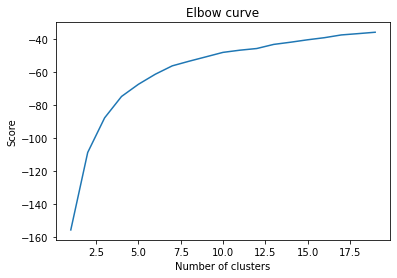

      title  num_player_small  num_player_big  game_time(min)  complexity  \
0  티켓 투 라이드                 2               2              16           2   
1       윙스팬                 2               2              55           3   
2        아줄                 2               2              12           1   
3        카탄                 3               3              42           2   
4      카르카손                 2               2              18           1   

   strategy  luck  interaction  cluster  
0         3     3            2        4  
1         3     3            3        4  
2         3     3            0        0  
3         3     3            4        4  
4         3     3            3        4  
cluster_candid
 :::: 
 0
cluster_candid
 :::: 
 1
cluster_candid
 :::: 
 4
cluster_candid
 :::: 
 4
cluster_candid
 :::: 
 0
kmeans_result:  ['스페이스 베이스', '야찌', '캔트 스탑', '킹 오브 도쿄', '스플렌더', '센추리: 향신료의 길', '모아보새', '하나비', '7 원더스', '레지사이드', '아줄']
Selected boardgames (5boardgames) : 럭키 넘버스,

In [ ]:
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import pylab as pl
from mlxtend.frequent_patterns import apriori, association_rules
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn import preprocessing
import warnings; warnings.simplefilter('ignore')

def ErrorLog(error):
    current_time = time.strftime("%Y.%m.%d/%H:%M:%S", time.localtime(time.time()))
    with open("Log.txt", "a") as f:
        f.write(f"[{current_time}] - {error}\n")

def apriori_encoding(r): ###튀는 데이터 넣는 용도인가?
    if r <= 0:
        return 0
    elif r >= 1:
        return 1

def do_apriori(_input_boardgames, _boardgames_df, _ratings_df):
    # Internal variables
    _apriori_result = []

    """ Remove the Nan title & join the dataset """
    Nan_title = _boardgames_df['title'].isna()
    _boardgames_df = _boardgames_df.loc[Nan_title == False]

    df = pd.merge(_ratings_df, _boardgames_df[['id', 'title']], left_on='board_game', right_on='id')
    df.drop(['timestamp', 'id'], axis=1, inplace=True)
    print(df.head())
    """ Prepare Apriori
        row : userId | col : movies """
    df_pivot = df.pivot(index='user_num', columns='title', values='rate').fillna(0)
  #  df_pivot = df_pivot.astype('int64')
    df_pivot = df_pivot.applymap(apriori_encoding) ##apriori endoding용도는??
    print(df_pivot)

    """ A-priori Algorithm """
    #calculate support and eradicate under min_support
    frequent_items = apriori(df_pivot, min_support=0.3, use_colnames=True)
    print("frequent_item" , frequent_items.head())

    # using association rules, compute the other parameter ex) confidence, lift ..
    association_indicator = association_rules(frequent_items, metric="lift", min_threshold=1)

    # sort by order of lift
    df_lift = association_indicator.sort_values(by=['lift'], ascending=False)

    """ Start recommendation """
    for selected_boardgames in _input_boardgames:
        num = 0
        df_selected = df_lift[df_lift['antecedents'].apply(lambda x: len(x) == 1 and next(iter(x)) == selected_boardgames)]
        df_selected = df_selected[df_selected['lift'] > 1.2]
        recommended_boardgames = df_selected['consequents'].values

        for boardgames in recommended_boardgames:
            for title in boardgames:
                if title not in _apriori_result and num < 10:
                    _apriori_result.append(title)
                    num += 1

    print("apriori_result: ", _apriori_result)
    return _apriori_result

def do_kmeans(_apriori_result, _input_boardgames, _boardgames_df):
    # record all clusters in _input_movies
    clusters = []
    _kmeans_result = []

    numeric_df = _boardgames_df[['title','num_player_small',	'num_player_big',	'game_time(min)',	'complexity',	'strategy',	'luck',	'interaction']]

    numeric_df.isnull().sum()
    numeric_df.dropna(inplace=True)

    minmax_processed = preprocessing.MinMaxScaler().fit_transform(numeric_df.drop(['title'], axis=1))
    df_numeric_scaled = pd.DataFrame(minmax_processed, index=numeric_df.index, columns=numeric_df.columns[:-1]) 

    """Apply K-means clustering"""
    # make elbow curve to determine value 'k'
    num_cluster = range(1, 20)
    kmeans = [KMeans(n_clusters=i) for i in num_cluster]
    score = [kmeans[i].fit(df_numeric_scaled).score(df_numeric_scaled) for i in range(len(kmeans))]

    # print elbow curve
    pl.plot(num_cluster, score)
    pl.xlabel("Number of clusters")
    pl.ylabel("Score")
    pl.title("Elbow curve")
    plt.show()  # maybe k=4 is appropriate

    # Fit K-means clustering for k=5
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df_numeric_scaled)  # result is kmeans_label

    # write back labels to the original numeric data frame
    numeric_df['cluster'] = kmeans.labels_
    print(numeric_df.head())

    # Search all clusters in user selected movies
    for boardgames1 in _input_boardgames:
        try:
            cluster_candid = numeric_df.loc[numeric_df["title"] == boardgames1, 'cluster'].values[0]
            print('cluster_candid\n :::: \n', cluster_candid)
            clusters.append(cluster_candid)
        except IndexError as e:
            msg = "There is No cluster in boardgames [" + boardgames1 + ']'
            ErrorLog(msg)
            print(msg)

    # Filtering movies that are not in clusters
    for boardgames2 in _apriori_result:
        try:
            cluster_tmp = numeric_df.loc[numeric_df["title"] == boardgames2, 'cluster'].values[0]
            if cluster_tmp in clusters:
                _kmeans_result.append(boardgames2)
        except IndexError as e:
            msg = "There is No cluster in boardgames [" + boardgames2 + ']'
            ErrorLog(msg)
            print(msg)

    return _kmeans_result

def compute_CF(_boardgames, _boardgames_users_compressed, _model, _n_recommendations, _boardgames_names):
    
    recommend_frame = []

    _model.fit(_boardgames_users_compressed)
    boardgames_index = process.extractOne(_boardgames, _boardgames_names['title'])[2]

    try:
        # find the closest movie compare to selected movie
        distances, indices = _model.kneighbors(_boardgames_users_compressed[boardgames_index], n_neighbors=_n_recommendations)
    except IndexError as e:
        msg = "There is No boardgame [" + _boardgames + '] in csr_matrix'
        print(msg)
        ErrorLog(msg)
        return []

    rec_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),
                                key=lambda x: x[1])[:0:-1]

    check = 0 #######
    for index in rec_indices:
        check = check +1
        print(check)
        print(index[1])
        try:
          print( _boardgames_names['title'][index[0]])
          recommend_frame.append({'Title': _boardgames_names['title'][index[0]], 'Distance': index[1]})
        except: print("err1")

    df = pd.DataFrame(recommend_frame, index=range(1, _n_recommendations))
    result = df['Title'].tolist()

    return result

def do_collaborative_filtering(_input_boardgames, _ratings_df, _boardgames_df):
    
    _collab_result = []
    
    boardgames_names = _boardgames_df[['title']]

    boardgames_users = _ratings_df.pivot(index=['user_num'], columns=['board_game'], values='rate').fillna(0)

    # by using csr_matrix, compress the sparse data frame
    boardgames_users_compressed = csr_matrix(boardgames_users.values)
    print(boardgames_users_compressed)

    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)

    # make a similar movie groups based on ratings
    model.fit(boardgames_users_compressed)

    for boardgames in _input_boardgames:
        num_recom = 4
        recommend = compute_CF(boardgames, boardgames_users_compressed, model, num_recom, boardgames_names)
        _collab_result.extend(recommend)

    return _collab_result


"""
Function : main

Parameter: _

Return:
        return : recommended movies
"""
def main(input_boardgames):

    final_result = ""

    final_result += "Selected boardgames (5boardgames) : " + ",".join(input_boardgames) + "\n\n" ##입력한 결과 출력
    print(final_result)

    # Read csv files
    boardgmae_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crawling/outcome/boardgamedata_1021.csv', sep='\t')
    ratings_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crawling/outcome/userdata_rate_1021.csv', sep='\t')

    # recommend based on a-priori & k-means
    apriori_result = do_apriori(input_boardgames, boardgmae_df, ratings_df)
    print("apriori_result: ", apriori_result)
    kmeans_result = do_kmeans(apriori_result, input_boardgames, boardgmae_df)
    print("kmeans_result: ", kmeans_result)

    # recommend based on collaborative filtering
    #collabo_result = do_collaborative_filtering(input_boardgames, ratings_df, boardgmae_df)
    #print("collabo_result: ", collabo_result)

    final_result += "A-priori & K-means clustering recommend boardgame : " + ",".join(kmeans_result) + "\n\n"
    #final_result += "Collaborative filtering recommend boardgame : " + ",".join(collabo_result) + "\n\n"

    print(final_result)
    f = open("result.txt", "w")
    f.write(final_result)
    f.close()

    return final_result




if __name__ == '__main__':
    main(['럭키 넘버스', '콰르토', '도블', '버글 브라더스', '롤 & 범프'])